# Функция модуляции передачи

In [56]:
import numpy as np
from PIL import Image, ImageFile
from matplotlib import pyplot as plt
from copy import deepcopy

In [57]:
STEP = 4 # шаг в пикселях между образцами
SAMPLES = 20 # количество обозреваемых строк в изображении

In [58]:
img1 = Image.open("1.png")
img1 = img1.rotate(5.71)
img2 = Image.open("2.png")
img2 = img2.rotate(5.71)

In [59]:
def get_rows_avgs(img : ImageFile, step : int = STEP, samples : int = SAMPLES, scaled : bool = True) -> tuple[list[int], list[float]]:
    """
        Функция расчитывает средние значения яркости изображения по горизонтальной оси с шагом `step`  
        Количество обозреваемых строк в изображениее `samples`  
        Если `scaled` - True, нормализует значения  
    """
    xs = [i for i in range(0, img.width, step)]
    ys = [0] * len(xs)
    samples_count = [0] * len(xs)

    pixels = img.load()

    for y in range(0, img.width, img.height // samples):
        for i in range(len(xs)):
            if pixels[xs[i], y][3] == 0:
                continue
            samples_count[i] += 1
            ys[i] += pixels[xs[i], y][0]
    
    for i in range(len(ys)):
        ys[i] /= samples_count[i]

    if scaled:
        mx = max(ys)
        for i in range(len(ys)):
            ys[i] /= mx

    return xs, ys

In [60]:
def find_transition_params(avgs : tuple[list[int], list[float]]) -> tuple[int, int, int]:
    """
        Находит начало, конец и середину перехода
    """

    start = finish = 0
    # yctm - близжайший y к 0.5
    # xctm - соотвесвтующий yctm x
    yctm, xctm = 0, 0

    for y in range(len(avgs[1])):
        if avgs[1][y] < 0.1:
            start = avgs[0][y]
        
        if finish == 0 and avgs[1][y] >= 0.9:
            finish = avgs[0][y]

        if yctm == 0:
            yctm = avgs[1][y]
            xctm = avgs[0][y]

        if abs(0.5 - yctm) > abs(0.5 - avgs[1][y]):
            yctm = avgs[1][y]
            xctm = avgs[0][y]
        

    return start, finish, xctm


In [61]:
def shrink_avgs(avgs : tuple[list[int], list[float]], start : int, finish : int) -> tuple[list[int], list[float]]:
    """
        Сокращает переходы до указанного диапазона
    """

    shrinked = deepcopy(avgs)

    while shrinked[0][0] < start:
        del shrinked[0][0]
        del shrinked[1][0]

    while shrinked[0][-1] > finish:
        del shrinked[0][-1]
        del shrinked[1][-1]

    return shrinked

In [62]:
def start_from_zero(avgs : tuple[list[int], list[float]]) -> tuple[list[int], list[float]]:
    sfz = deepcopy(avgs)
    for i in range(len(sfz[0])):
        sfz[0][i] = i * STEP

    return sfz

In [63]:
def set_center_to(avgs : tuple[list[int], list[float]], center : int) -> tuple[list[int], list[float]]:
    centered = deepcopy(avgs)
    middle = find_transition_params(centered)[2]
    
    print(middle, center)

    while middle > center:
        del centered[0][0]
        del centered[1][0]

        middle = find_transition_params(centered)[2]

    return centered

In [64]:
def align_from_center(avgs : tuple[list[int], list[float]]) -> tuple[list[int], list[float]]:
    aligned = deepcopy(avgs)

    for i in range(len(avgs[0]) // 2):
        aligned[1][len(aligned[1]) - 1 - i] = aligned[1][i]

    return aligned

In [65]:
def get_line_blur(avgs : tuple[list[int], list[float]]) -> tuple[list[int], list[float]]:
    middle = find_transition_params(avgs)[2]

    blur = avgs[0], [0]

    for i in range(len(blur[0])):
        blur[0][i] -= middle
        
    for i in range(1, len(avgs[1])):
        blur[1].append(abs(avgs[1][i-1] - avgs[1][i]))

    blur[0].append(blur[0][-1] + STEP)
    blur[1].append(0)

    return blur    

In [66]:
def calc_MTF(blur : tuple[list[int], list[float]]):
    x, y = blur

    fft_result = np.fft.fft(y)
    fft_result_normalized = np.abs(fft_result) / np.max(np.abs(fft_result))

    MTF = np.abs(fft_result_normalized)

    freqs = np.fft.fftfreq(len(x), d=STEP)

    possitive_mask = freqs >= 0
    freqs_possitive = freqs[possitive_mask]

    MTF_possitive = MTF[possitive_mask]

    idx = np.argsort(freqs_possitive)
    freqs_sorted = freqs_possitive[idx]
    MTF_sorted = MTF_possitive[idx]

    return freqs_sorted, MTF_sorted

In [67]:
def plot_avgs(avgs : tuple[list[int], list[float]], title : str = "") -> None:
    """
        Отображает на графике средние значения яркости  
        Подписывает график `title`  
    """
    plt.figure(figsize=(10, 5))
    plt.plot(avgs[0], avgs[1])
    plt.axhline(y=0.9, color='r', linewidth=1)
    plt.axhline(y=0.1, color='r', linewidth=1)
    plt.title(title)
    plt.xlabel("Пискели")
    plt.ylabel("Средняя яркость")
    plt.yticks([y * 0.1 for y in range(0, 11)])
    # plt.xticks(avgs[0])
    plt.grid()

In [68]:
def plot_line_blur(blur : tuple[list[int], list[float]], title : str = "") -> None:
    plt.figure(figsize=(10, 5))
    plt.plot(blur[0], blur[1])
    plt.title(title)
    plt.xlabel("Пискели")
    plt.ylabel("Краевая функция")
    plt.grid()

In [69]:
def plot_MTF(freqs, MTF, title : str ="") -> None:
    plt.figure(figsize=(10, 5))
    plt.plot(freqs, MTF)
    plt.title(title)
    plt.xlabel("Частота")
    plt.ylabel("MTF")
    plt.grid()

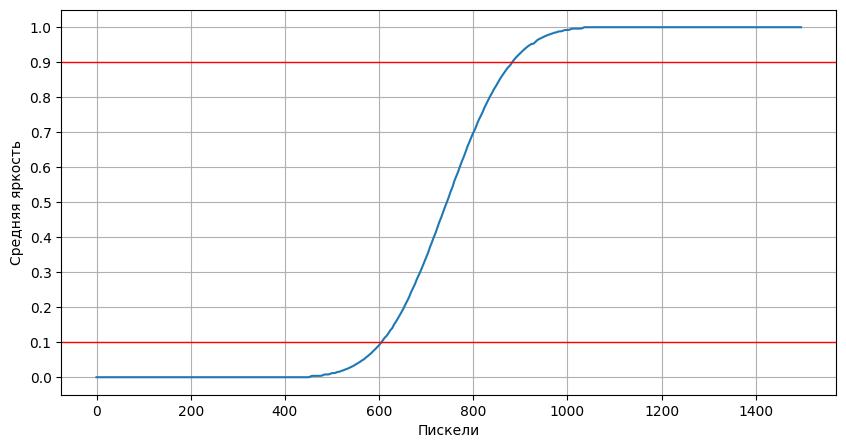

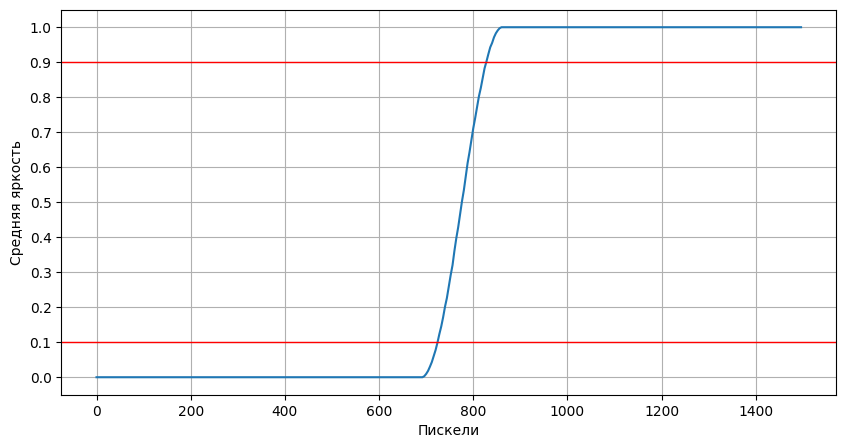

In [70]:
avgs1 = get_rows_avgs(img1)
avgs2 = get_rows_avgs(img2)

plot_avgs(avgs1)
plot_avgs(avgs2)

In [71]:
start1, finish1, middle1 = find_transition_params(avgs1)
width1 = finish1 - start1
start2, finish2, middle2 = find_transition_params(avgs2)
width2 = finish2 - start2

print("Параметры переходов")
print(f"Переход 1: [{start1}, {finish1}] (ширина: {width1}), центр перехода - {middle1}")
print(f"Переход 2: [{start2}, {finish2}] (ширина: {width2}), центр перехода - {middle2}")

Параметры переходов
Переход 1: [604, 884] (ширина: 280), центр перехода - 744
Переход 2: [724, 828] (ширина: 104), центр перехода - 776


(0, 280, 140)
(120, 224, 172)


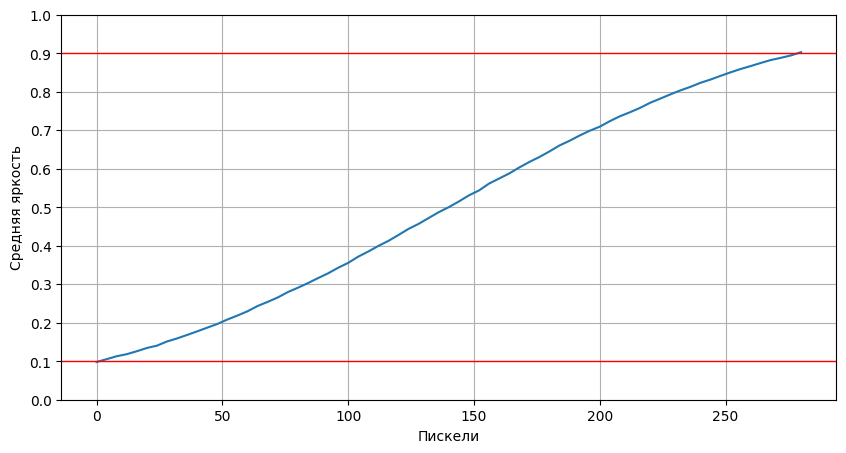

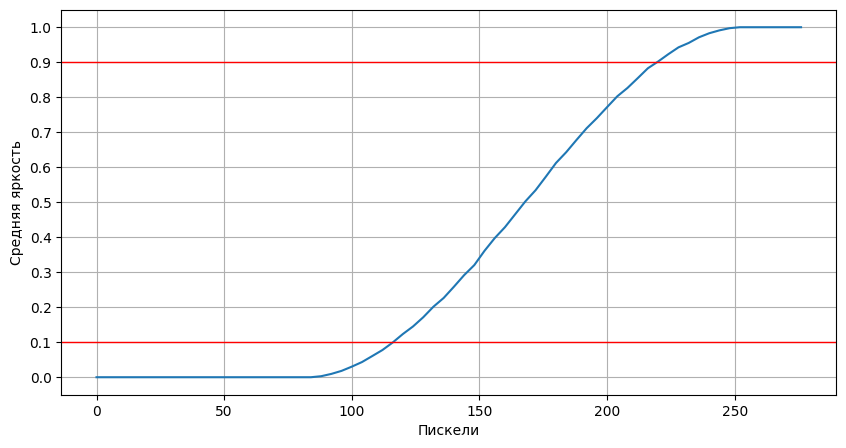

In [72]:
shrinked1 = start_from_zero(shrink_avgs(avgs1, start1, finish1))
shrinked2 = start_from_zero(shrink_avgs(avgs2, start1, finish1))

print(find_transition_params(shrinked1))
print(find_transition_params(shrinked2))

del shrinked2[1][0]
del shrinked2[0][-1]

plot_avgs(shrinked1)
plot_avgs(shrinked2)

In [73]:
start1, finish1, middle1 = find_transition_params(shrinked1)
width1 = finish1 - start1
start2, finish2, middle2 = find_transition_params(shrinked2)
width2 = finish2 - start2

print("Параметры переходов")
print(f"Переход 1: [{start1}, {finish1}] (ширина: {width1}), центр перехода - {middle1}")
print(f"Переход 2: [{start2}, {finish2}] (ширина: {width2}), центр перехода - {middle2}")

Параметры переходов
Переход 1: [0, 280] (ширина: 280), центр перехода - 140
Переход 2: [116, 220] (ширина: 104), центр перехода - 168


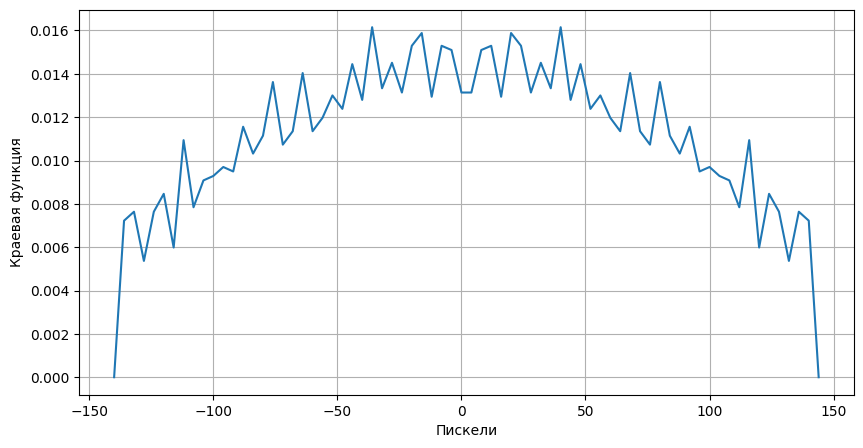

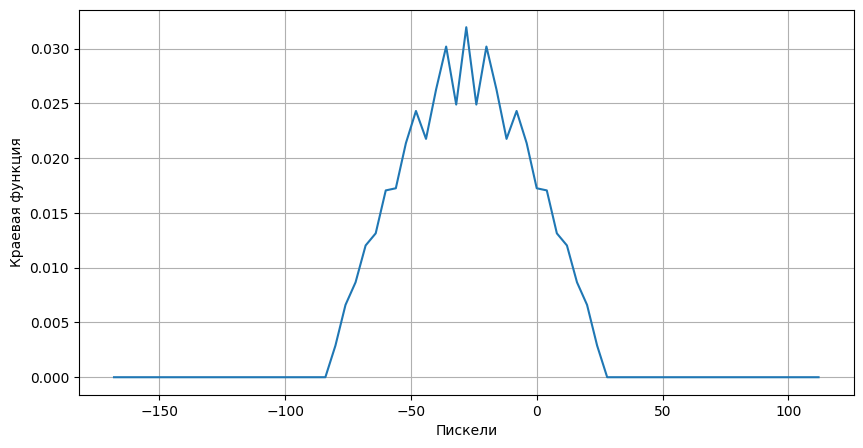

In [74]:
blur1 = align_from_center(get_line_blur(shrinked1))
blur2 = align_from_center(get_line_blur(shrinked2))

plot_line_blur(blur1)
plot_line_blur(blur2)

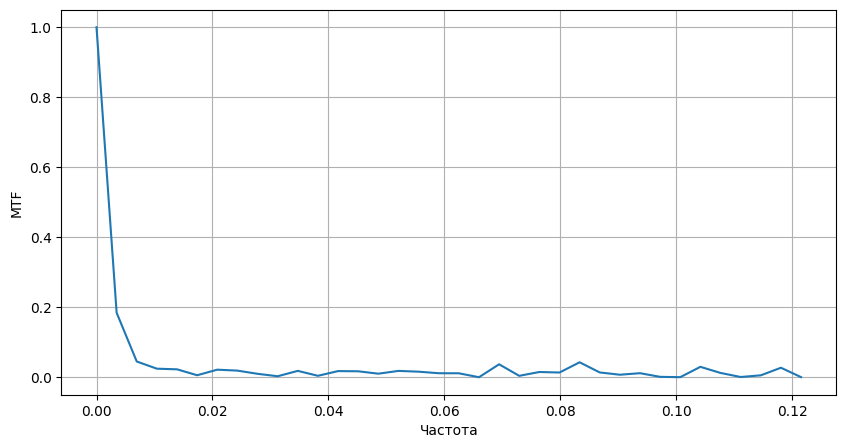

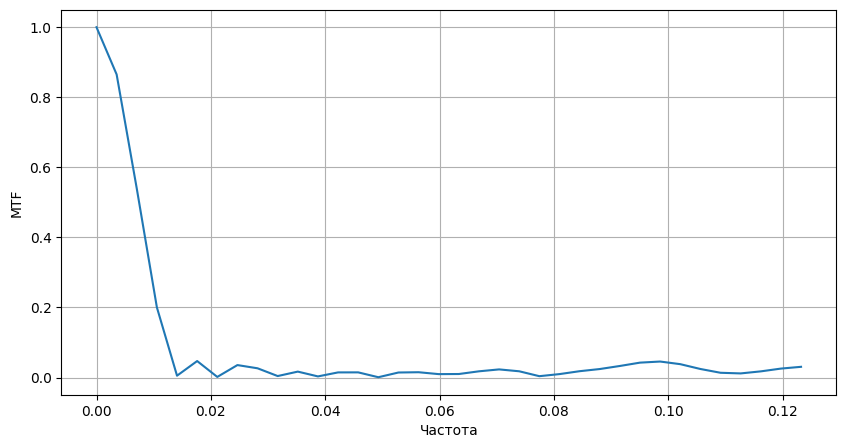

In [75]:
freqs1, mtf1 = calc_MTF(blur1)
freqs2, mtf2 = calc_MTF(blur2)

plot_MTF(freqs1, mtf1)
plot_MTF(freqs2, mtf2)

# Оценка качества вопроизведения системой мелкой детали

**Формула нахождения спектра квадратной аперутры**  
$
\operatorname{sinc}(v) = \begin{cases} 
\frac{\sin(\pi v)}{\pi v} & ; v \neq 0 \\
1 & ; v = 0 
\end{cases}
$  
где 𝑙 – ширина штриха, 𝑝𝑥; 𝜈 – частота, $𝑝𝑥^{−1}$.

Было выбрана 3 штриха:
- шириной 10 px;
- шириной 20 px;
- шириной 30 px;

In [76]:
def sinc(v : float, width : int) -> float:
    if v == 0: return 1
    return np.sin(np.pi * width * v) / (np.pi * width * v)


In [77]:
def get_spectrum_intensity(width : int, freqs : list[float]) -> list[float]:
    spectrum = []

    for v in freqs:
        spectrum.append(abs(sinc(width, v)))

    return spectrum

In [78]:
def get_spectrums(widths: tuple[int], freqs : list[float]) -> list[list[int]]:
    spectrums = []

    for width in widths:
        spectrum = get_spectrum_intensity(width, freqs)
        spectrums += [(freqs, spectrum, f"Ширина штриха = {width} px")]
    
    return spectrums

In [79]:
def get_spectrums_spreads(widths, mtf, freqs):
    spectrums = []
    for width in widths:
        spectrum = get_spectrum_intensity(width, freqs)
        for i in range(len(spectrum)):
            spectrum[i] *= mtf[i]
        spectrums.append((freqs, spectrum, f"Система {1 if mtf is mtf1 else 2} | Ширина штриха = {width} px"))
    return spectrums

In [80]:
def get_ESF_v(spectrum, freqs):
    x, min_freq = 0, float('inf')
    
    for i in range(1, len(freqs)):
        if freqs[i] is np.nan: continue
        if freqs[i] < min_freq:
            min_freq = freqs[i]
            x = i
    f3 = spectrum[x]
    h = []
    print(x, f3)
    for x in spectrum:
        h.append((x + f3 + 2) / 4)
    return h

In [86]:
def display_spectrum_intensity(freqs : list[float], intensities : list[list[float]], label : str = "") -> None:
    plt.figure(figsize=(10, 5))
    plt.title(label)
    for intensity in intensities:
        plt.plot(intensity[0], intensity[1], label=intensity[2])
    plt.xlabel("Коеф передачи модуляции")
    plt.ylabel("Пространственная частота, px^-1")
    plt.grid()
    plt.legend()
    plt.show()


In [82]:
widths = 10, 20, 30

(36,) 36
(36,) 36
(36,) 36


C:\Users\mayor\AppData\Local\Temp\ipykernel_2404\555134781.py:3: RuntimeWarning: invalid value encountered in scalar divide
  return np.sin(np.pi * width * v) / (np.pi * width * v)


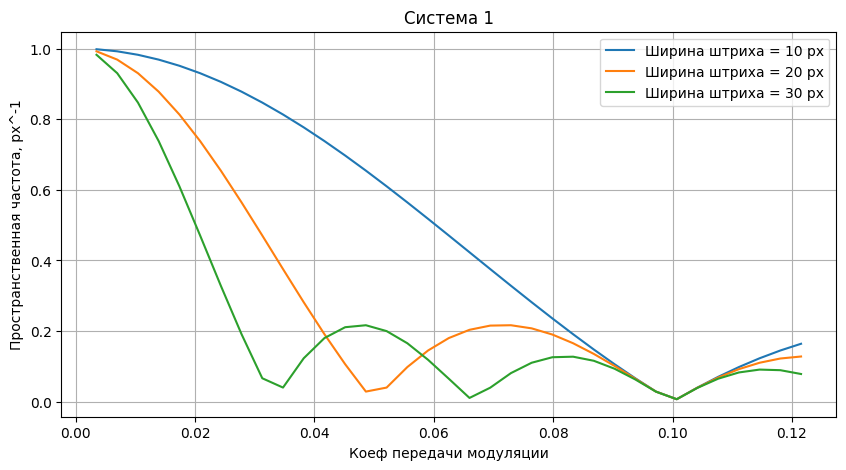

(36,) 36
(36,) 36
(36,) 36


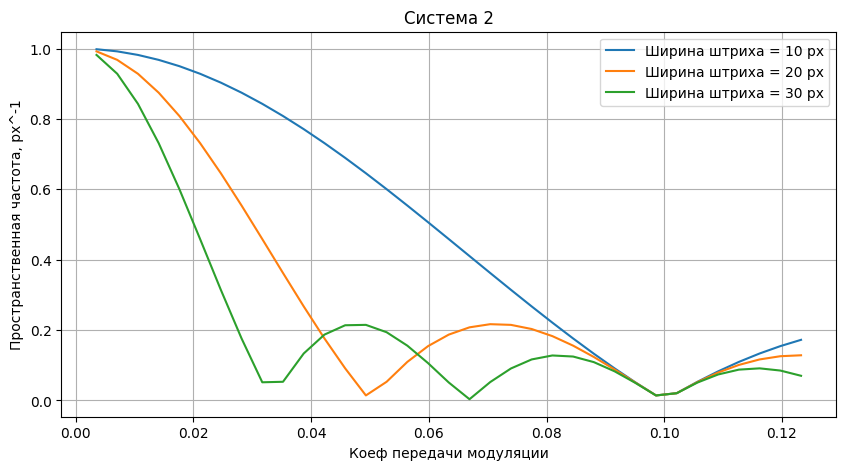

In [83]:
spectrums1 = get_spectrums(widths, freqs1)
spectrums2 = get_spectrums(widths, freqs2)

display_spectrum_intensity(freqs1, spectrums1, "Система 1")
display_spectrum_intensity(freqs2, spectrums2, "Система 2")

(36,) 36
(36,) 36
(36,) 36


C:\Users\mayor\AppData\Local\Temp\ipykernel_2404\555134781.py:3: RuntimeWarning: invalid value encountered in scalar divide
  return np.sin(np.pi * width * v) / (np.pi * width * v)


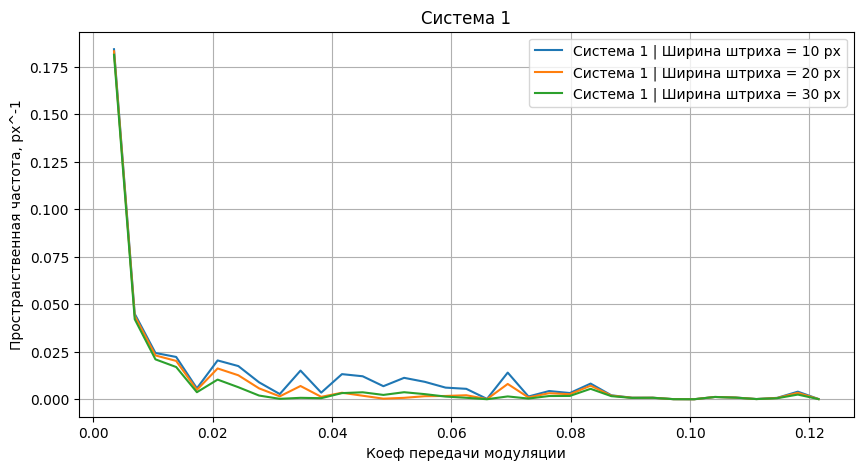

(36,) 36
(36,) 36
(36,) 36


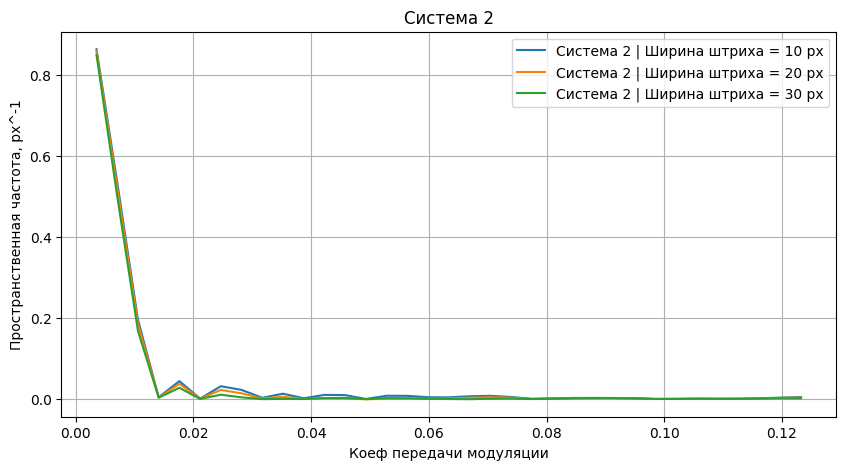

In [84]:
spectrums_spread1 = get_spectrums_spreads(widths, mtf1, freqs1)
spectrums_spread2 = get_spectrums_spreads(widths, mtf2, freqs2)

display_spectrum_intensity(freqs1, spectrums_spread1, "Система 1")
display_spectrum_intensity(freqs1, spectrums_spread2, "Система 2")

1 0.18412316391196953
1 0.1830287981002404
1 0.18121352780101974
(36,) 36
(36,) 36
(36,) 36


C:\Users\mayor\AppData\Local\Temp\ipykernel_2404\555134781.py:3: RuntimeWarning: invalid value encountered in scalar divide
  return np.sin(np.pi * width * v) / (np.pi * width * v)


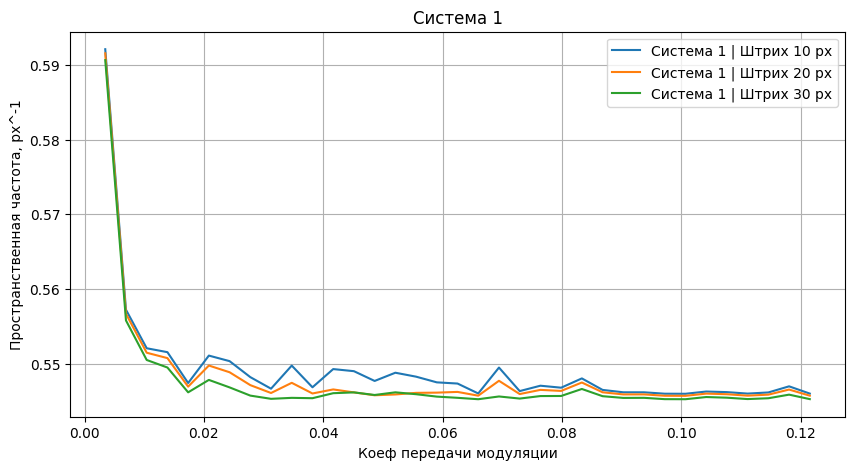

1 0.8634345747565355
1 0.8581571797714194
1 0.8494045293890568
(36,) 36
(36,) 36
(36,) 36


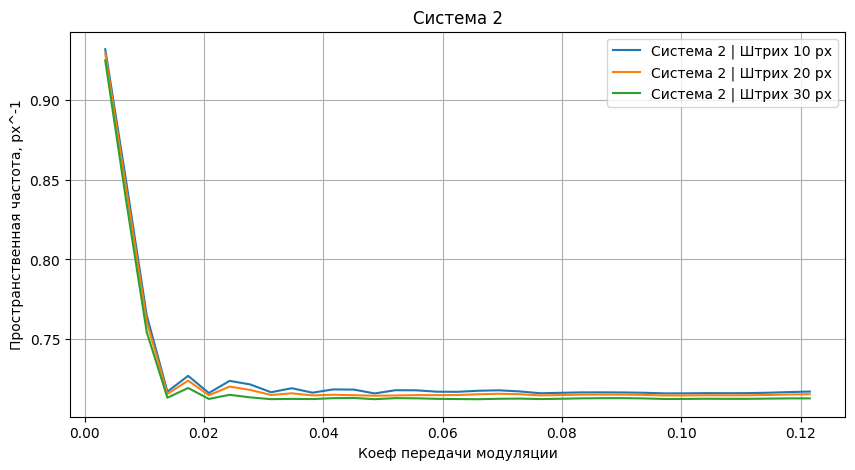

In [85]:
def get_ESF(mtf, freqs, widths):
    h = []
    for width in widths:
        spectrum = get_spectrum_intensity(width, freqs)
        for i in range(len(spectrum)):
            spectrum[i] *= mtf[i]
        h.append([freqs1, get_ESF_v(spectrum, freqs), f"Система {1 if mtf is mtf1 else 2} | Штрих {width} px"])

    return h        

display_spectrum_intensity(freqs1, get_ESF(mtf1, freqs1, widths), "Система 1")
display_spectrum_intensity(freqs2, get_ESF(mtf2, freqs2, widths), "Система 2")